In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
dataset = pd.read_csv("C:/Users/aruni/PycharmProjects/script/Bitcoin.csv")
dataset.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,USD
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,USD
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,USD
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,USD
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,USD


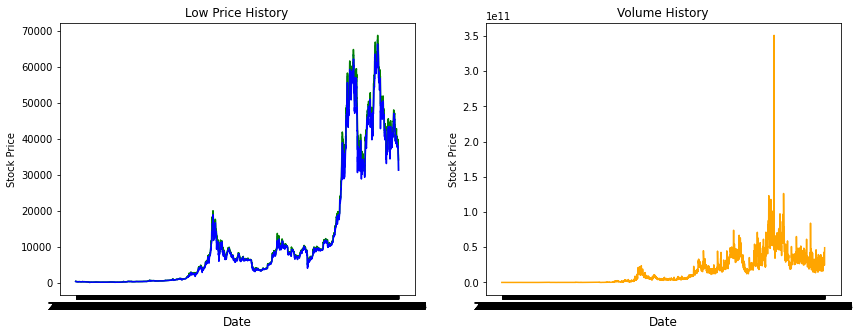

In [3]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.plot(dataset["Date"], dataset["Close"])
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Price History")

# Second Subplot
ax1.plot(dataset["Date"], dataset["High"], color="green")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("High Price History")

# Third Subplot
ax1.plot(dataset["Date"], dataset["Low"], color="blue")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Low Price History")

# Fourth Subplot
ax2.plot(dataset["Date"], dataset["Volume"], color="orange")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price")
ax2.set_title("Volume History")
plt.show()

In [4]:

dataset['Date'] = pd.to_datetime(dataset['Date'], format=('%Y-%m-%d'))
group = dataset.groupby('Date')

In [5]:
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2792 entries, 0 to 2791
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2792 non-null   datetime64[ns]
 1   Open      2792 non-null   float64       
 2   High      2792 non-null   float64       
 3   Low       2792 non-null   float64       
 4   Close     2792 non-null   float64       
 5   Volume    2792 non-null   int64         
 6   Currency  2792 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 152.8+ KB


,Date,Open,High,Low,Close,Volume,Currency
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,USD
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,USD
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,USD
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,USD
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,USD


In [6]:
date1 = datetime(2014, 9, 17)
date2 = datetime(2022, 5, 9)

day_price = group['Close'].mean()

delta = date2 - date1
days_look = delta.days + 1

data = day_price[len(day_price) - days_look:len(day_price)]

scl = MinMaxScaler()

data = data.values.reshape(data.shape[0], 1)
scale_data = scl.fit_transform(data)

In [7]:
SEQ_LEN = 50
WINDOW_SIZE = SEQ_LEN - 1

BATCH_SIZE=64

DROPOUT = 0.2


def load_data(data_raw, seq_len):
    data = []

    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])

    data = np.array(data)
    train_split = 0.8

    num_data = data.shape[0]

    num_train = int(train_split * num_data)

    data = np.array(data)

    x_train = data[:num_train, :-1, :]

    y_train = data[:num_train, -1, :]

    x_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return [x_train, y_train, x_test, y_test]


x_train, y_train, x_test, y_test = load_data(scale_data, SEQ_LEN)


In [8]:
from keras.layers import Bidirectional, Dropout, Activation

model = Sequential()

# First Layer
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, x_train.shape[-1])))
model.add(Dropout(DROPOUT))

# Second Layer
model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(DROPOUT))

# Third Layer
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

# Set activation function
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 49, 98)           19992     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 49, 98)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 49, 196)          154448    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 49, 196)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 98)               96432     
 nal)                                                            
                                                        

In [9]:
from keras.callbacks import EarlyStopping

history = model.fit(x_train, y_train, epochs=100, batch_size=BATCH_SIZE, shuffle=False,
                    validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

Epoch 1/100
35/35 [==============================] - 35s 391ms/step - loss: 0.0019 - val_loss: 0.0371
Epoch 2/100
35/35 [==============================] - 9s 255ms/step - loss: 0.0019 - val_loss: 0.0058
Epoch 3/100
35/35 [==============================] - 9s 266ms/step - loss: 0.0017 - val_loss: 0.0523
Epoch 4/100
35/35 [==============================] - 8s 239ms/step - loss: 0.0024 - val_loss: 0.0670
Epoch 5/100
35/35 [==============================] - 8s 241ms/step - loss: 7.8066e-04 - val_loss: 0.0076
Epoch 6/100
35/35 [==============================] - 9s 241ms/step - loss: 8.6636e-04 - val_loss: 0.0405
Epoch 7/100
35/35 [==============================] - 8s 243ms/step - loss: 8.7608e-04 - val_loss: 0.0101
Epoch 8/100
35/35 [==============================] - 8s 237ms/step - loss: 4.0798e-04 - val_loss: 0.0089
Epoch 9/100
35/35 [==============================] - 8s 241ms/step - loss: 5.4557e-04 - val_loss: 0.0208
Epoch 10/100
35/35 [==============================] - 9s 251ms/step - 

18/18 [==============================] - 4s 42ms/step


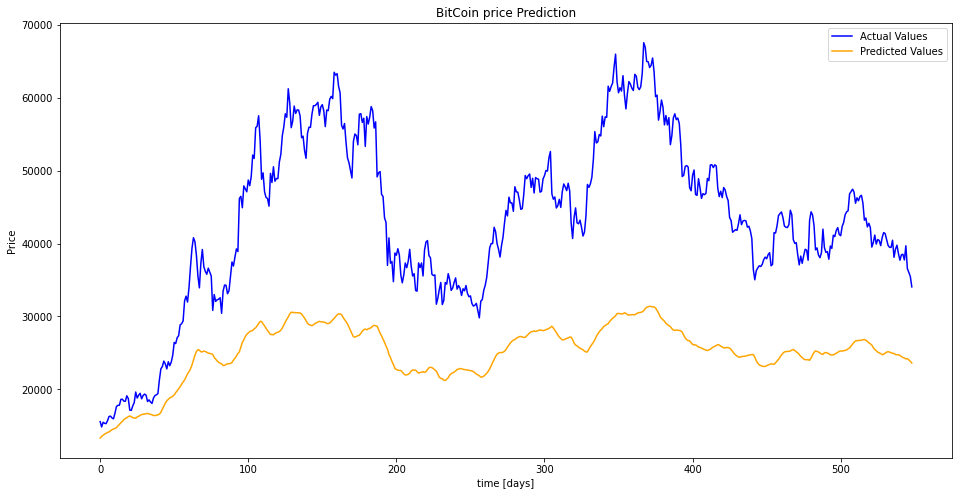

In [10]:
predict_prices = model.predict(x_test)

plt.figure(figsize=(16,8))
plt.plot(scl.inverse_transform(y_test), label="Actual Values", color='blue')
plt.plot(scl.inverse_transform(predict_prices), label="Predicted Values", color='Orange')

plt.title('BitCoin price Prediction')
plt.xlabel('time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show()

<AxesSubplot:title={'center':'Bitcoin Weighted Price'}, xlabel='Date'>

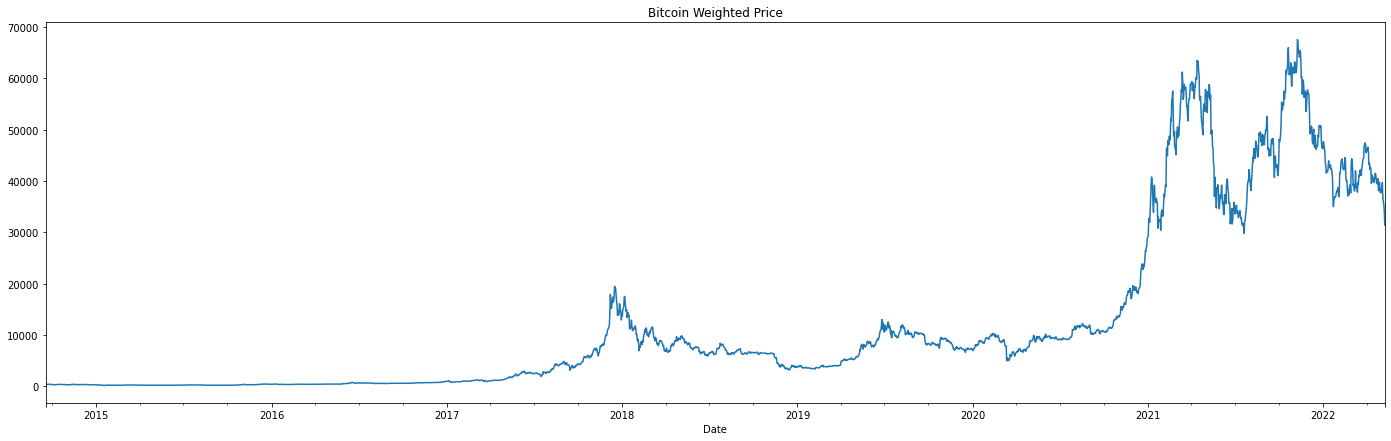

In [11]:
dataset.set_index("Date").Close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

In [12]:
x_test
x_test.shape

(549, 49, 1)

In [13]:
from keras.layers import GRU

model_name = 'GRU'

model = Sequential()
model.add(GRU(units=100,
              return_sequences=True,
              input_shape=(WINDOW_SIZE,x_train.shape[-1])))
model.add(Dropout(DROPOUT))
model.add(GRU(units=100))
model.add(Dropout(DROPOUT))
model.add(Dense(1, activation='linear'))
#model.compile(loss='mse', optimizer='adam')

print(model.summary())



# Set activation function
#model.add(Activation('relu'))
# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(x_train, y_train, epochs=100, batch_size=BATCH_SIZE, shuffle=False,
                    validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 49, 100)           30900     
                                                                 
 dropout_2 (Dropout)         (None, 49, 100)           0         
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 91,601
Trainable params: 91,601
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
35/35 [==========================

18/18 [==============================] - 2s 22ms/step


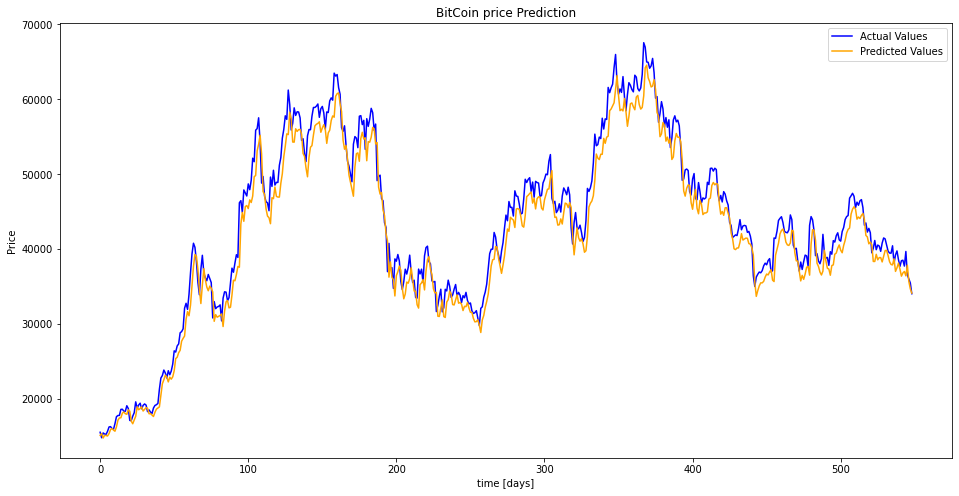

In [14]:
predict_prices = model.predict(x_test)

plt.figure(figsize=(16,8))
plt.plot(scl.inverse_transform(y_test), label="Actual Values", color='blue')
plt.plot(scl.inverse_transform(predict_prices), label="Predicted Values", color='Orange')

plt.title('BitCoin price Prediction')
plt.xlabel('time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show()

In [15]:
lookback_period = 5


testX_last_5_days = x_test[x_test.shape[0] - lookback_period :  ]

testX_last_5_days.shape

(5, 49, 1)

In [16]:
testX_last_5_days.reshape(-1,)

array([0.60790327, 0.60504596, 0.61765604, 0.62343588, 0.60944499,
       0.60692487, 0.6259312 , 0.63385758, 0.64970558, 0.6554602 ,
       0.65771722, 0.69213936, 0.69670261, 0.70171423, 0.69573302,
       0.67311813, 0.68414325, 0.67801915, 0.68669445, 0.68920391,
       0.6733751 , 0.63851386, 0.64292275, 0.62487547, 0.63221308,
       0.62368844, 0.58383356, 0.5928155 , 0.60824162, 0.58997128,
       0.5991412 , 0.59722723, 0.58672797, 0.60318862, 0.61322791,
       0.61132297, 0.59875387, 0.58707473, 0.58331164, 0.58305288,
       0.59772915, 0.56299266, 0.57966697, 0.58757196, 0.57029898,
       0.55701858, 0.56821064, 0.56910448, 0.55754653, 0.60504596,
       0.61765604, 0.62343588, 0.60944499, 0.60692487, 0.6259312 ,
       0.63385758, 0.64970558, 0.6554602 , 0.65771722, 0.69213936,
       0.69670261, 0.70171423, 0.69573302, 0.67311813, 0.68414325,
       0.67801915, 0.68669445, 0.68920391, 0.6733751 , 0.63851386,
       0.64292275, 0.62487547, 0.63221308, 0.62368844, 0.58383

In [17]:
predicted_5_days_forecast_price_test_x = []

for i in range(5):
  predicted_forecast_price_test_x = model.predict(testX_last_5_days[i:i+1])

  predicted_forecast_price_test_x = scl.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
  # print(predicted_forecast_price_test_x)
  predicted_5_days_forecast_price_test_x.append(predicted_forecast_price_test_x)

print("Forecast for the next 5 Days Beyond the actual trading days ", np.array(predicted_5_days_forecast_price_test_x))

1/1 [==============================] - 0s 38ms/step
Forecast for the next 5 Days Beyond the actual trading days  [[[36444.586]]

 [[37871.77 ]]

 [[35708.76 ]]

 [[34716.62 ]]

 [[34145.51 ]]]


In [18]:
predicted_5_days_forecast_price_test_x = np.array(predicted_5_days_forecast_price_test_x)

predicted_5_days_forecast_price_test_x.reshape(-1,)

array([36444.586, 37871.77 , 35708.76 , 34716.62 , 34145.51 ],
      dtype=float32)

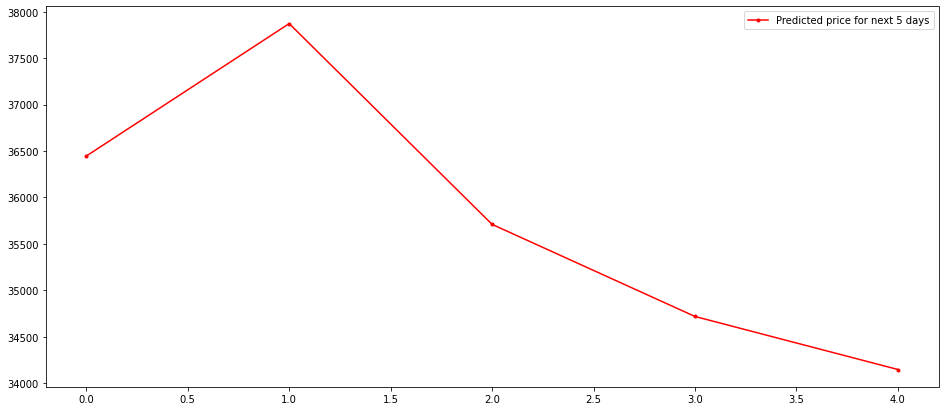

In [19]:
plt.figure(figsize=(16,7))

plt.plot(predicted_5_days_forecast_price_test_x.reshape(-1,)
, 'r', marker='.', label='Predicted price for next 5 days')



plt.legend()

plt.show()

In [20]:
rmse_lstm_test = math.sqrt(mean_squared_error(y_test, predict_prices))

print('Test RMSE: %.3f' % rmse_lstm_test)

Test RMSE: 0.036


In [21]:
lookback_period = 50


testX_last_5_days = x_test[x_test.shape[0] - lookback_period :  ]

testX_last_5_days.shape

(50, 49, 1)

In [22]:
testX_last_5_days.reshape(-1,)

array([0.5600269 , 0.56841886, 0.57227927, ..., 0.54010575, 0.53217833,
       0.52418042])

In [23]:
predicted_5_days_forecast_price_test_x = []

for i in range(50):
  predicted_forecast_price_test_x = model.predict(testX_last_5_days[i:i+1])

  predicted_forecast_price_test_x = scl.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
  # print(predicted_forecast_price_test_x)
  predicted_5_days_forecast_price_test_x.append(predicted_forecast_price_test_x)

print("Forecast for the next 5 Days Beyond the actual trading days ", np.array(predicted_5_days_forecast_price_test_x))

1/1 [==============================] - 0s 25ms/step
Forecast for the next 5 Days Beyond the actual trading days  [[[40570.31 ]]

 [[39865.812]]

 [[39528.86 ]]

 [[40503.586]]

 [[41179.098]]

 [[42153.484]]

 [[42648.574]]

 [[42824.082]]

 [[44686.04 ]]

 [[45342.95 ]]

 [[45666.633]]

 [[45355.207]]

 [[44014.746]]

 [[44299.324]]

 [[44094.418]]

 [[44518.863]]

 [[44767.492]]

 [[43950.24 ]]

 [[41849.848]]

 [[41637.047]]

 [[40719.055]]

 [[40948.   ]]

 [[40602.406]]

 [[38365.766]]

 [[38362.805]]

 [[39319.656]]

 [[38584.1  ]]

 [[38882.74 ]]

 [[38880.332]]

 [[38302.99 ]]

 [[39063.996]]

 [[39814.164]]

 [[39855.27 ]]

 [[39138.574]]

 [[38322.605]]

 [[37957.84 ]]

 [[37906.098]]

 [[38723.36 ]]

 [[37038.22 ]]

 [[37522.133]]

 [[38139.203]]

 [[37338.53 ]]

 [[36404.055]]

 [[36829.895]]

 [[37030.918]]

 [[36444.586]]

 [[37871.77 ]]

 [[35708.76 ]]

 [[34716.62 ]]

 [[34145.51 ]]]


In [24]:
predicted_5_days_forecast_price_test_x = np.array(predicted_5_days_forecast_price_test_x)

predicted_5_days_forecast_price_test_x.reshape(-1,)

array([40570.31 , 39865.812, 39528.86 , 40503.586, 41179.098, 42153.484,
       42648.574, 42824.082, 44686.04 , 45342.95 , 45666.633, 45355.207,
       44014.746, 44299.324, 44094.418, 44518.863, 44767.492, 43950.24 ,
       41849.848, 41637.047, 40719.055, 40948.   , 40602.406, 38365.766,
       38362.805, 39319.656, 38584.1  , 38882.74 , 38880.332, 38302.99 ,
       39063.996, 39814.164, 39855.27 , 39138.574, 38322.605, 37957.84 ,
       37906.098, 38723.36 , 37038.22 , 37522.133, 38139.203, 37338.53 ,
       36404.055, 36829.895, 37030.918, 36444.586, 37871.77 , 35708.76 ,
       34716.62 , 34145.51 ], dtype=float32)

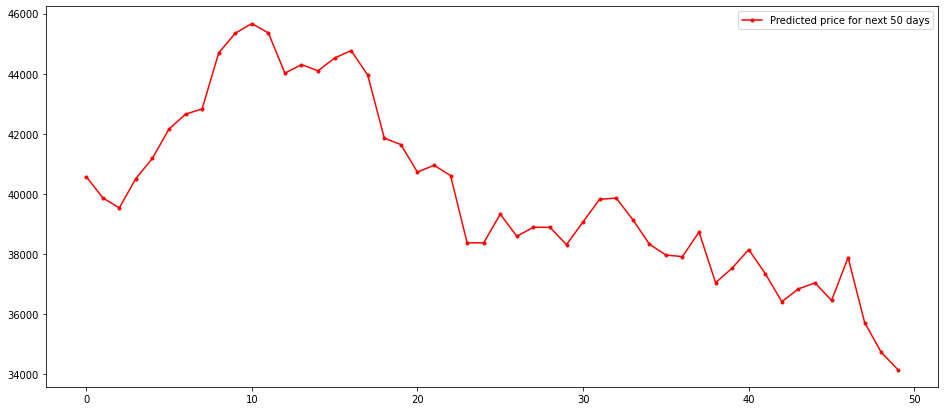

In [25]:
plt.figure(figsize=(16,7))

plt.plot(predicted_5_days_forecast_price_test_x.reshape(-1,)
, 'r', marker='.', label='Predicted price for next 50 days')



plt.legend()

plt.show()

In [58]:
file = pd.read_csv("C:/Users/aruni/PycharmProjects/script/Bitcoin.csv")
file = file.set_index(pd.DatetimeIndex(file['Date'].values))
file

,Date,Open,High,Low,Close,Volume,Currency
2014-09-17,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,USD
2014-09-18,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,USD
2014-09-19,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,USD
2014-09-20,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,USD
2014-09-21,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,USD
...,...,...,...,...,...,...,...
2022-05-05,2022-05-05,39695.746094,39789.281250,35856.515625,36575.140625,43106256317,USD
2022-05-06,2022-05-06,36573.183594,36624.359375,35482.132812,36040.921875,37795577489,USD
2022-05-07,2022-05-07,36042.503906,36129.925781,34940.824219,35501.953125,24375896406,USD
2022-05-08,2022-05-08,35502.941406,35502.941406,33878.964844,34059.265625,36763041910,USD


In [73]:

# User Invested amount
#Amount
Amount = int(input("Enter the Amount you invested:$"))
#Date(yyyy-mm-dd)
Date = input("Enter the Date on investment(yyyy-mm-dd)(2022-05-09):")
print('\t', Amount,"\n",Date)

	 100 
 2022-05-09


In [74]:
#Low price & High price of the day to store and return
#low_1 = data.get('Low')
#High_1 = data.get('High')
Low_1 = 'Low'
High_1 = 'High'
Value_1 = file[Low_1][Date]
Value_2 = file[High_1][Date]

In [78]:
#Quantity of crypto assest
invest_1 = int(Amount)/ Value_1
invest_2 = int(Amount)/ Value_2
print(invest_1)

0.0031910860998657876


In [87]:
#profit of crypto
print(file[Low_1][-1])
profit_1 = (round(invest_1,4) * file[Low_1][-1]) - int(Amount)
profit_2 = (round(invest_2,4) * file[High_1][-1]) - int(Amount)
print(profit_1)


31337.29296875
0.2793375000000111


In [92]:
#Amount made as profit or loss

print('the profit and loss price between $',profit_1, 'and also $',profit_2, 'on',file["Date"][-1])

the profit and loss price between $ 0.2793375000000111 and also $ -0.7891988281250093 on 2022-05-09


In [96]:
#return of investment

rot1 =  profit_1/ int(Amount) * 100
rot2 =  profit_2/ int(Amount) * 100
print("The return of investment will be between",round(rot1,2),"% and",round(rot2,2),"%")

The return of investment will be between 0.28 % and -0.79 %
